In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=130)

In [3]:
from case import *
from PetscBinaryIO import PetscBinaryIO
from fsmpfuncs import weight

Ux/Utip =  0.41
AoA = 67.7063708403
Re =  700.0
dt =  0.0018


In [4]:
d = np.loadtxt('3-FrequencyResponse/j006_n013_optimal_gains.txt', unpack=True)
ω, j, nP = d[0,:].real, d[1,:].real.astype(int), d[2,0].real.astype(int)
G, e = d[4,:], d[5,:].real

In [5]:
R, iR = weight(dx, dy)

H = (y[-1]-y[0])

y = np.concatenate([ y[:1], np.concatenate([y[1:] + k*H for k in range(nP)])])
dy = np.diff(y)
yp = 0.5*(y[1:] + y[:-1])
dyp = np.diff(yp)
yu = yp
yv = y[:-1]

n1 = n
n = len(y)-1
pshape = (n, m)
ushape = (n, m-1)
vshape = (n, m)
                    
xi = np.concatenate([xi for k in range(nP)])
eta = np.concatenate([eta + k*H for k in range(nP)])
ds = np.concatenate([ds for k in range(nP)])
l1 = l
l = xi.size

In [9]:
freqs = [6, 12]

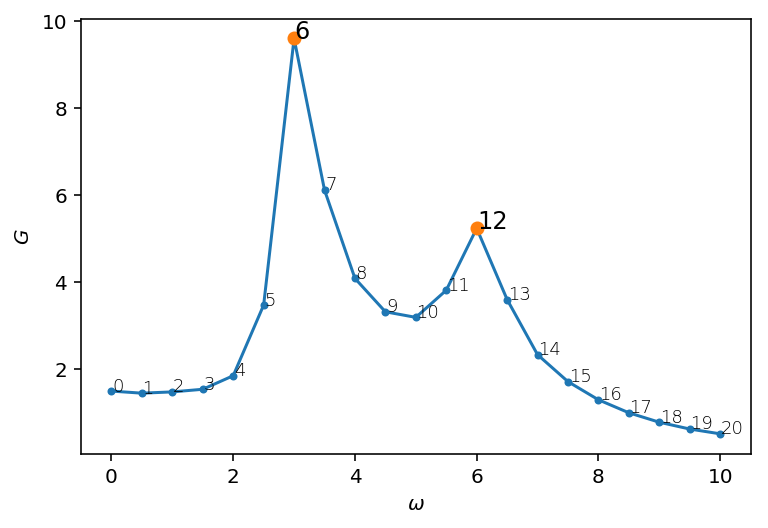

In [10]:
plt.plot(ω, G, '.-')
plt.plot(ω[freqs], G[freqs], 'o')
for k, ωk in enumerate(ω):
    plt.text(ωk+0.01, G[k]+0.01, '%d'%k, color='0',
             va='baseline', ha='left', fontsize=12 if k in freqs else 9,
             weight='normal' if k in freqs else 'light')

plt.xlabel(r'$\omega$')
plt.ylabel(r'$G$');

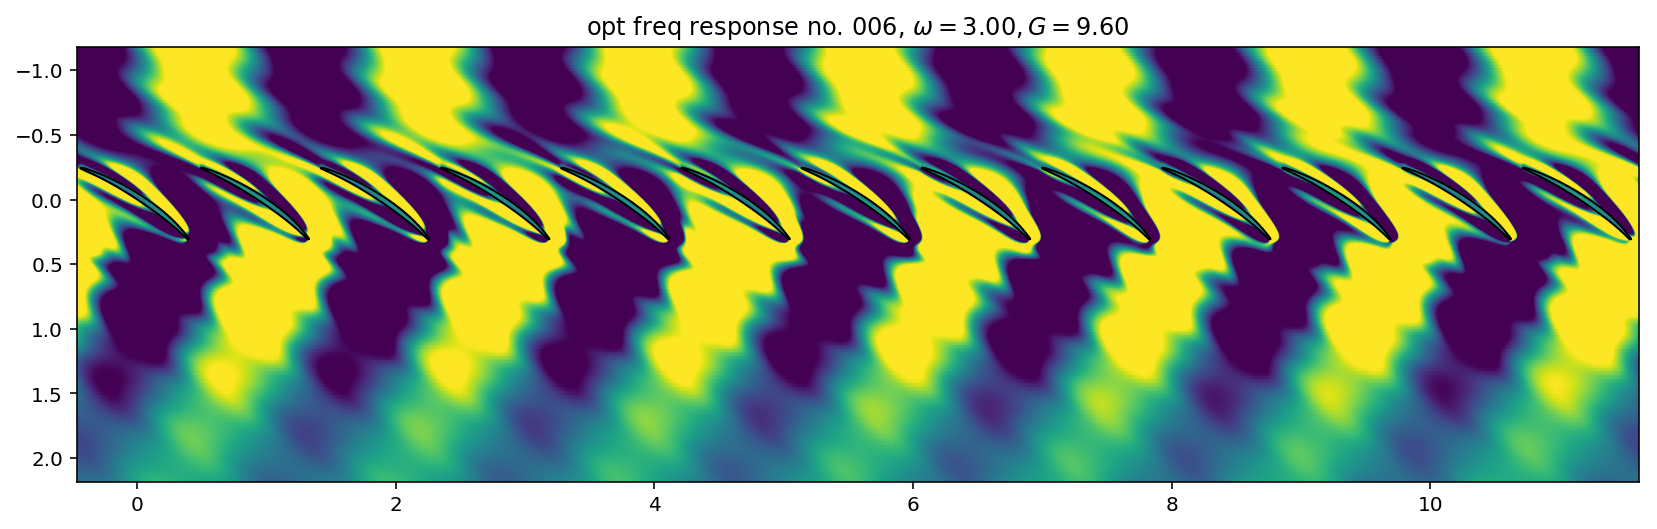

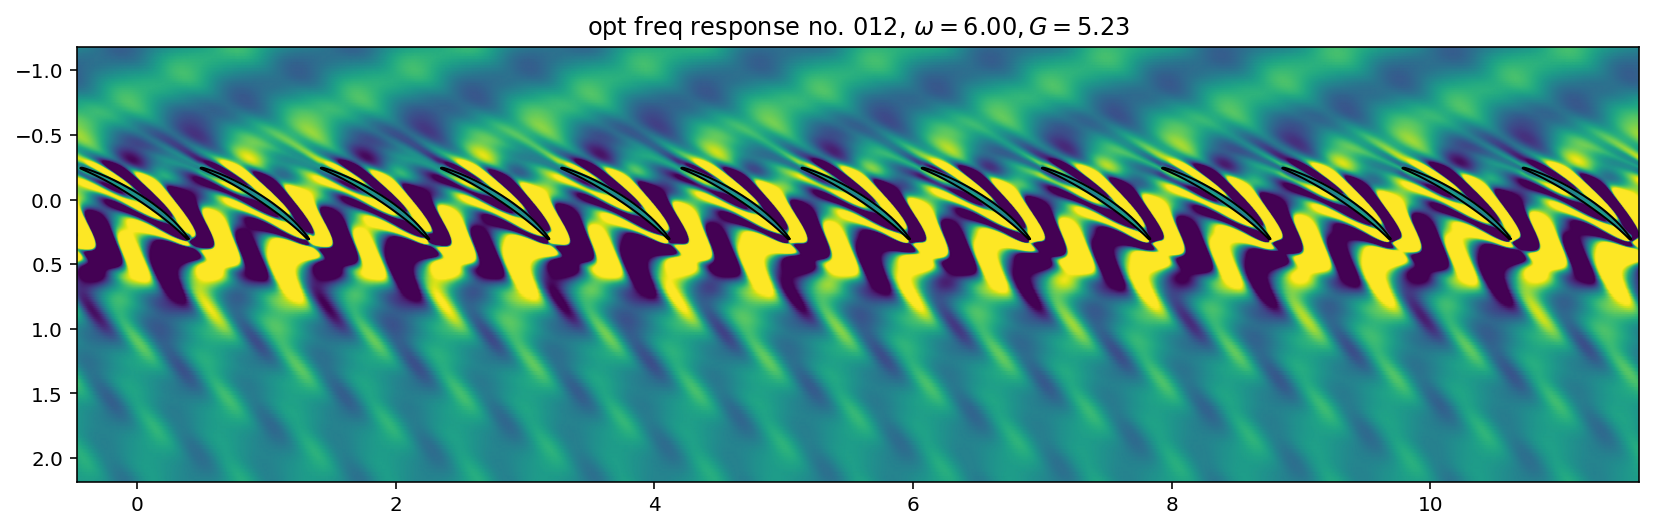

In [11]:
x0, x1 = -1, 2
y0, y1 = y[0], y[-1]

for freq in freqs:
    jP = j[freq]
    ρk = np.exp(1j*jP*2*np.pi/nP)
    
    _vec = PetscBinaryIO().readBinaryFile('3-FrequencyResponse/j%03d_n%03d_w%05.2f_f_i%03d.dat'%(jP, nP, ω[freq], 0))[0]
    vec = np.empty(_vec.shape, dtype=np.complex)
    vec[:]=_vec[:]
    del _vec
    
    iRq = iR.dot(vec[:n1*(m-1) + n1*m])

    u = iRq[:n1*(m-1)].reshape((n1, m-1))
    v = iRq[n1*(m-1):].reshape((n1, m))
    #ϕ = vec[n1*(m-1) + n1*m:n1*(m-1) + 2*n1*m].reshape((n1, m))
    
    u = np.vstack([ρk**(k-1)*u for k in range(nP)])
    v = np.vstack([ρk**(k-1)*v for k in range(nP)])
    #ϕ = np.vstack([ρk**(k-1)*ϕ for k in range(nP)])
    
    plt.figure(figsize=(14,4))
    plt.pcolormesh(yu, xu, u.T.real, rasterized=True, shading='gouraud', vmin=0.05*np.min(u.real), vmax=0.05*np.max(u.real))
    plt.plot(np.asarray(np.split(eta, nP)).T, np.asarray(np.split(xi, nP)).T, 'k', lw=1);
    plt.axis('equal')
    plt.title(r'opt freq response no. %03d, $ω = %.2f, G= %.2f$'%(freq, ω[freq], G[freq]))
    plt.ylim(x1, x0)
    plt.xlim(y0, y1)